In [3]:
# For first-time use of TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\VIJAY SHARON
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Task 1: Sentiment Labeling


In [4]:
import pandas as pd
from textblob import TextBlob

# Load dataset
df = pd.read_csv("test.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Function for sentiment labeling
def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['body'].apply(get_sentiment)


 Task 2: Exploratory Data Analysis (EDA)

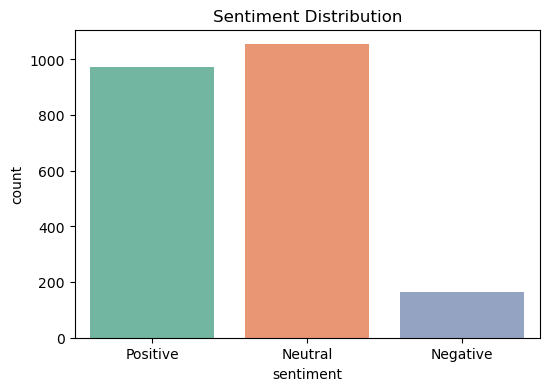

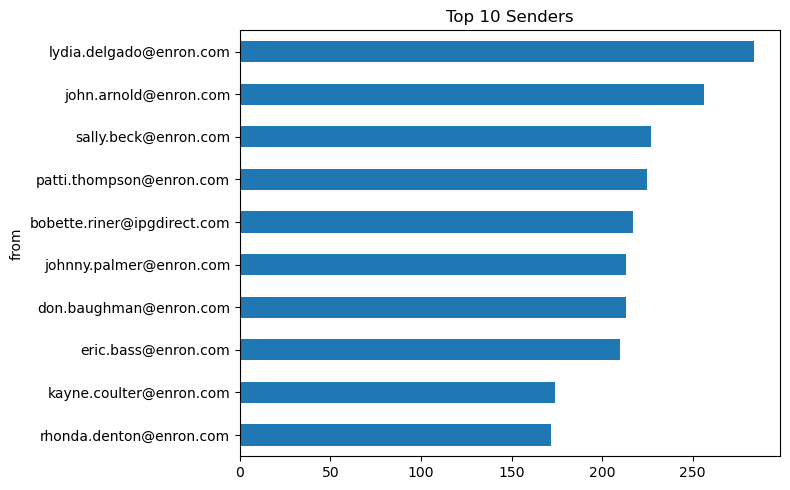

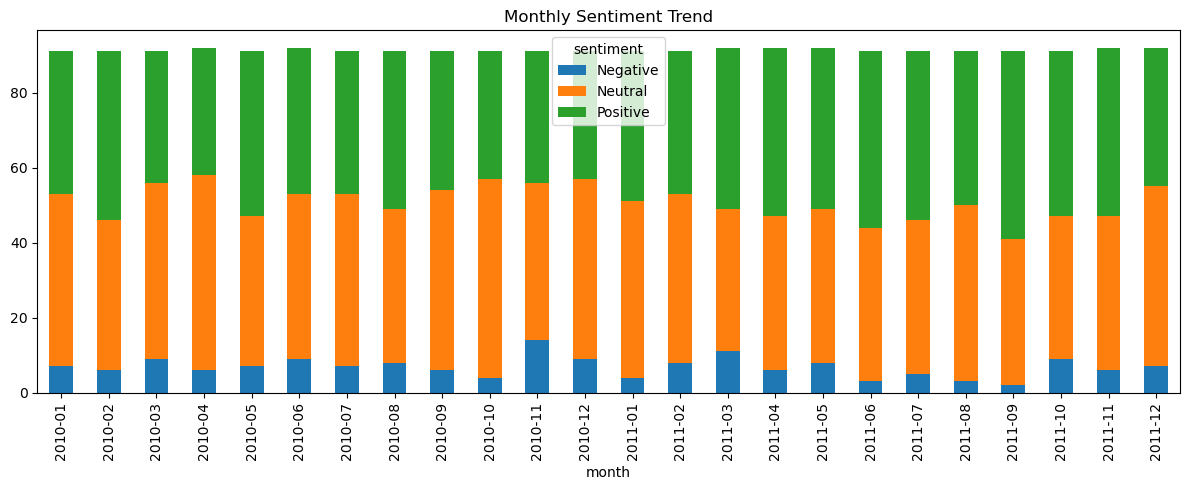

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Sentiment Distribution')
plt.savefig("sentiment_distribution.png", dpi=360)
plt.show()

# 2. Messages per employee
top_senders = df['from'].value_counts().head(10)
plt.figure(figsize=(8, 5))
top_senders.plot(kind='barh', title='Top 10 Senders')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("top_10_senders.png", dpi=360)
plt.show()

# 3. Sentiment over time
df['month'] = df['date'].dt.to_period('M')
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 5), title='Monthly Sentiment Trend')
plt.tight_layout()
plt.savefig("monthly_sentiment_trend.png", dpi=360)
plt.show()


Task 3: Employee Score Calculation

In [6]:
def sentiment_score(label):
    return {'Positive': 1, 'Negative': -1, 'Neutral': 0}.get(label, 0)

df['score'] = df['sentiment'].apply(sentiment_score)
df['month'] = df['date'].dt.to_period('M')

monthly_scores = df.groupby(['from', 'month'])['score'].sum().reset_index()
monthly_scores.rename(columns={'from': 'employee', 'score': 'monthly_score'}, inplace=True)


Task 4: Employee Ranking

In [7]:
# Top 3 Positive and Negative per month
def top_rankings(df, month_period):
    monthly = df[df['month'] == month_period]
    top_pos = monthly.sort_values(by=['monthly_score', 'employee'], ascending=[False, True]).head(3)
    top_neg = monthly.sort_values(by=['monthly_score', 'employee']).head(3)
    return top_pos, top_neg

# Example: Show for most recent month
latest_month = monthly_scores['month'].max()
top_positive, top_negative = top_rankings(monthly_scores, latest_month)

print("Top Positive Employees:\n", top_positive)
print("\nTop Negative Employees:\n", top_negative)


Top Positive Employees:
                      employee    month  monthly_score
143   kayne.coulter@enron.com  2011-12              5
191  patti.thompson@enron.com  2011-12              5
71        eric.bass@enron.com  2011-12              4

Top Negative Employees:
                         employee    month  monthly_score
23   bobette.riner@ipgdirect.com  2011-12              0
95         john.arnold@enron.com  2011-12              2
119      johnny.palmer@enron.com  2011-12              2


 Task 5: Flight Risk Identification

In [8]:
# Filter only negative messages
negatives = df[df['sentiment'] == 'Negative']

# Rolling 30-day window
negatives['date'] = pd.to_datetime(negatives['date'])
negatives = negatives.sort_values(['from', 'date'])

# Flag users with ≥ 4 negative messages within any 30-day window
from collections import defaultdict
from datetime import timedelta

flight_risks = set()
grouped = negatives.groupby('from')

for employee, group in grouped:
    dates = group['date'].sort_values().tolist()
    for i in range(len(dates) - 3):
        if (dates[i + 3] - dates[i]) <= timedelta(days=30):
            flight_risks.add(employee)
            break

print("Flight Risk Employees:\n", flight_risks)


Flight Risk Employees:
 {'john.arnold@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'sally.beck@enron.com', 'bobette.riner@ipgdirect.com', 'rhonda.denton@enron.com', 'patti.thompson@enron.com'}


C:\Users\VIJAY SHARON L\AppData\Local\Temp\ipykernel_31872\3039517379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negatives['date'] = pd.to_datetime(negatives['date'])


 Task 6: Predictive Modeling (Linear Regression)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
df['message_length'] = df['body'].apply(lambda x: len(str(x)))
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

# Aggregate features monthly
features = df.groupby(['from', 'month']).agg({
    'score': 'sum',
    'message_length': 'mean',
    'word_count': 'mean',
    'body': 'count'
}).rename(columns={'body': 'message_count'}).reset_index()

# Prepare data
X = features[['message_length', 'word_count', 'message_count']]
y = features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R2 Score: 0.42688878757528737
MSE: 3.9839189141467877
